## Compute Sagnac Frequency - Backscatter Correction

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert


from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from acoustics.signal import phase_spectrum, angle_spectrum

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-09-19 00:00")
config['tend'] = UTCDateTime("2023-09-19 10:00")

# config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-10, 448+10

config['path_to_data'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [4]:
def __load_romy_raw_data(seeds, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime

    st0 = Stream()

    for seed in seeds:

        print(f" -> loading {seed}...")

        try:
            st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
        except:
            print(f" -> failed for {seed}")

        st0 += st00

    st0 = st0.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

In [25]:
def __get_values(ff, psd, fph, ph, f_sagn, method=None, multitaper=False):

    from numpy import argmax, sqrt, where, argmin, gradient, mean
    from acoustics.signal import phase_spectrum

    ## specify f-band around Sagnac frequency
    fl = f_sagn-2
    fu = f_sagn+2

    ## get index of Sagnac peak
    idx_fs = where(psd == max(psd[(ff > fl) & (ff < fu)]))[0][0]

    if multitaper:
        ## compute gradient
        psd_d = abs(gradient(psd))

        ## cut psd below f_sagn -10 Hz and above f_sagn + 10 Hz
        psd_d1 = psd_d[(ff < f_sagn) & (ff > f_sagn - 10)]
        psd_d2 = psd_d[(ff > f_sagn) & (ff < f_sagn + 10)]

        ## get index of maximum gradient
        idx1 = where(psd_d == max(psd_d1))[0][0]
        idx2 = where(psd_d == max(psd_d2))[0][0]

        ## get index in the center of the stronges changes (= center of plateau)
        idx_fs = int( (idx2-idx1) /2 + idx1 )

    ## estimate Sagnac frequency
    f_sagn_est = ff[idx_fs]

    ## estimate AC value at Sagnac peak
    # AC_est = max(psd[(ff > fl) & (ff < fu)])
    AC_est = psd[idx_fs]

    ## estimate DC value at ff = 0
    DC_est = psd[0]

    ## estimate phase at Sagnac peak
    if method == "fft":
        phase_est = ph[idx_fs] ## select phase of Sagnac
    else:
        idx_ph = argmin(abs(fph - f_sagn_est)) ## finde index of phase closest to sagnac frequency
        phase_est = ph[idx_ph] ## select phase of Sagnac

    return f_sagn_est, sqrt(AC_est), sqrt(DC_est), phase_est

In [8]:
def __get_fft(signal_in, dt, window=None):

    '''

    Calculating a simple 1D FastFourierSpectrum of a time series.

    RETURN:

    frequencies, spectrum, phase

    '''

    from scipy.fft import fft, fftfreq, fftshift
    from scipy import signal
    from numpy import angle, imag

    ## determine length of the input time series
    n = int(len(signal_in))


    ## calculate spectrum (with or without window function applied to time series)
    if window:
        win = signal.get_window(window, n);
        spectrum = fft(signal_in * win)
    else:
        spectrum = fft(signal_in)

    ## calculate frequency array
    frequencies = fftfreq(n, d=dt)


    ## correct amplitudes of spectrum
    magnitude = abs(spectrum) * 2.0 / n


    phase = angle(spectrum, deg=False)
    # phase = imag(spectrum)

    ## return the positive frequencies
    return frequencies[0:n//2], magnitude[0:n//2], phase[0:n//2]

In [9]:
def __welch_psd(arr, dt, twin_sec=60):

    from scipy.signal import welch
    from scipy.signal.windows import hann

    nblock = int(1/dt * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    ff, Pxx = welch(arr,
                    fs=1/dt,
                    window=win, noverlap=overlap,
                    nfft=nblock,
                    scaling="density",
                    return_onesided=True)

    return ff, Pxx

## NEW ULLI

In [10]:
interval_seconds = 60

In [11]:
sagn = read(root_path+"Downloads/mseed/30min/DROMY_FJU_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+interval_seconds)
mon1 = read(root_path+"Downloads/mseed/30min/DROMY_F1V_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+interval_seconds)
mon2 = read(root_path+"Downloads/mseed/30min/DROMY_F2V_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+interval_seconds)

In [12]:
for tr in sagn:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon1:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon2:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

In [13]:
# sagn.interpolate(20000);
# mon1.interpolate(20000);
# mon2.interpolate(20000);

In [14]:
# sagn.plot();
# mon1.plot();
# mon2.plot();

## Processing

In [35]:
f_f, psd_f, pha_f = __get_fft(mon1[0].data, mon1[0].stats.delta, window=None)

pha_f = np.unwrap(pha_f)
psd_f = psd_f**2

In [16]:
f_m, psd_m = __multitaper_psd(mon1[0].data, mon1[0].stats.delta, n_win=2)

DPSS using interpolation 300001 100000


In [17]:
f_w, psd_w = __welch_psd(mon1[0].data, mon1[0].stats.delta, twin_sec=interval_seconds)

In [18]:
f_pha, pha = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)

In [19]:
fs_w, ac_w, dc_w, ph_w = __get_values(f_w, psd_w, f_pha, pha, 303.05, multitaper=False)

In [20]:
fs_m, ac_m, dc_m, ph_m = __get_values(f_m, psd_m, f_pha, pha, 303.05, multitaper=True)

In [36]:
fs_f, ac_f, dc_f, ph_f = __get_values(f_f, psd_f, f_f, pha_f, 303.05, method="fft", multitaper=False)

In [37]:
f_pha1, pha1 = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)
f_pha2, pha2 = phase_spectrum(mon2[0].data, mon2[0].stats.sampling_rate)
f_pha, pha = phase_spectrum(sagn[0].data, sagn[0].stats.sampling_rate)

## Plotting

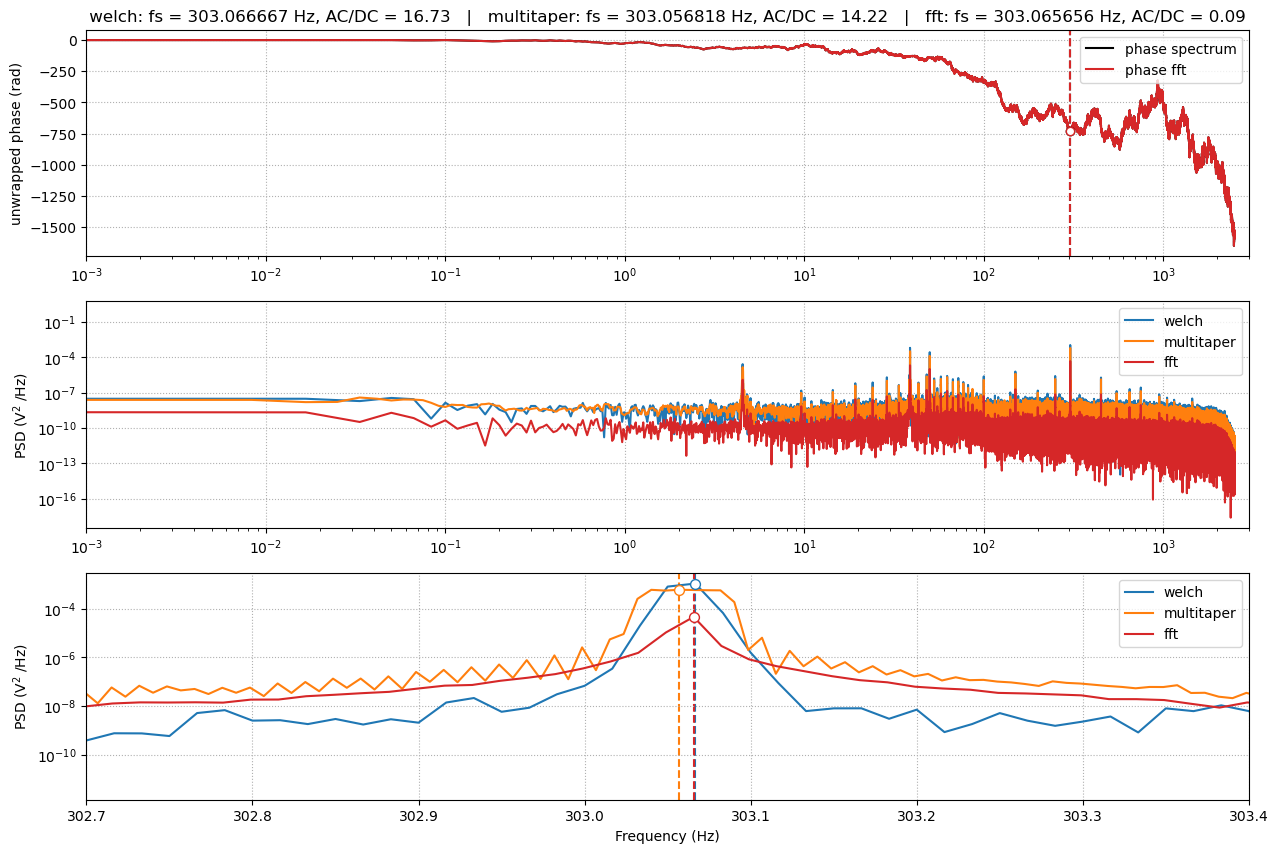

In [39]:
def __makeplot():

    Nrow = 3

    fig, ax = plt.subplots(Nrow, 1, figsize=(15, 10))

    ax[0].semilogx(f_pha1, pha1, color="k", label="phase spectrum", zorder=2)
    ax[0].scatter(fs_w, ph_w, color="w", edgecolor="k", zorder=3)
    ax[0].axvline(fs_w,  color="k", ls="--", zorder=2)

    ax[0].semilogx(f_f, pha_f, color="tab:red", label="phase fft", zorder=2)
    ax[0].scatter(fs_f, ph_f, color="w", edgecolor="tab:red", zorder=3)
    ax[0].axvline(fs_f,  color="tab:red", ls="--", zorder=2)


    ax[1].loglog(f_w, psd_w, label="welch")
    ax[1].loglog(f_m, psd_m, label="multitaper")
    ax[1].loglog(f_f, psd_f, label="fft", color="tab:red")

    ax[1].loglog(f_w[0], psd_w[0], marker="o", label="", color="tab:blue")
    ax[1].loglog(f_m[0], psd_m[0], marker="o", label="", color="tab:orange")
    ax[1].loglog(f_f[0], psd_f[0], marker="o", label="", color="tab:red")

    ax[2].semilogy(f_w[(f_w > 300) & (f_w < 304)], psd_w[(f_w > 300) & (f_w < 304)], label="welch")
    ax[2].semilogy(f_m[(f_m > 300) & (f_m < 304)], psd_m[(f_m > 300) & (f_m < 304)], label="multitaper")
    ax[2].semilogy(f_f[(f_f > 300) & (f_f < 304)], psd_f[(f_f > 300) & (f_f < 304)], label="fft", color="tab:red")

    ax[2].scatter(fs_w, ac_w**2, s=50, color="white", edgecolors="tab:blue", zorder=2)
    ax[2].scatter(fs_m, ac_m**2, s=50, color="white", edgecolor="tab:orange", zorder=2)
    ax[2].scatter(fs_f, ac_f**2, s=50, color="white", edgecolor="tab:red", zorder=2)

    ax[2].axvline(fs_w,  color="tab:blue", ls="--", zorder=1)
    ax[2].axvline(fs_m, color="tab:orange", ls="--", zorder=1)
    ax[2].axvline(fs_f, color="tab:red", ls="--", zorder=1)

    for i in range(Nrow):
        ax[i].grid(ls=":", zorder=0)
        ax[i].legend(loc=1)

    ax[0].set_xlim(1e-3, 3e3)
    ax[1].set_xlim(1e-3, 3e3)
    ax[2].set_xlim(302.7, 303.4)

    # ax[1].set_xlabel("Frequency (Hz)")
    ax[2].set_xlabel("Frequency (Hz)")

    ax[0].set_ylabel("unwrapped phase (rad)")
    ax[1].set_ylabel("PSD (V$^2$ /Hz)")
    ax[2].set_ylabel("PSD (V$^2$ /Hz)")

    ac_dc_w = float(np.sqrt( ac_w / dc_w ))
    ac_dc_m = float(np.sqrt( ac_m / dc_m ))
    ac_dc_f = float(np.sqrt( ac_f / dc_f ))

    title_m = f"multitaper: fs = {round(fs_m,6)} Hz, AC/DC = {round(ac_dc_m,2)}"
    title_w = f"welch: fs = {round(fs_w,6)} Hz, AC/DC = {round(ac_dc_w,2)}"
    title_f = f"fft: fs = {round(fs_f,6)} Hz, AC/DC = {round(ac_dc_f,2)}"

    ax[0].set_title(f" {title_w}   |   {title_m}   |   {title_f} ")

    plt.show();
    return fig

fig = __makeplot()

fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_compare_welch_multitaper_fft_{interval_seconds}s.jpeg", format="jpeg", dpi=200, bbox_inches='tight')

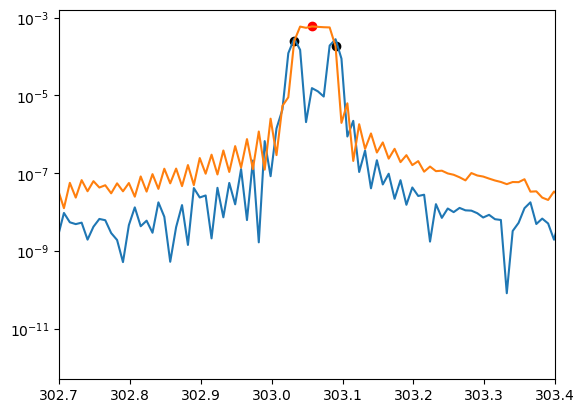

In [24]:
psd_m_d = abs(np.gradient(psd_m))


psd_m_d1 = psd_m_d[(f_m < fs_m) & (f_m > fs_m - 10)]
psd_m_d2 = psd_m_d[(f_m > fs_m) & (f_m < fs_m + 10)]

idx1 = np.where(psd_m_d == max(psd_m_d1))[0][0]
idx2 = np.where(psd_m_d == max(psd_m_d2))[0][0]

idx = int( (idx2-idx1) /2 + idx1 )

f_m[idx1], f_m[idx2], psd_m[idx1], psd_m[idx2]


plt.semilogy(f_m[(f_m > 300) & (f_m < 304)], psd_m_d[(f_m > 300) & (f_m < 304)], label="multitaper")
plt.semilogy(f_m[(f_m > 300) & (f_m < 304)], psd_m[(f_m > 300) & (f_m < 304)], label="multitaper")
plt.xlim(302.7, 303.4)

plt.scatter(f_m[idx1], psd_m[idx1], color="k")
plt.scatter(f_m[idx2], psd_m[idx2], color="k")
plt.scatter(f_m[idx], psd_m[idx], color="red")



## Automatic

In [ ]:
sagn = read(root_path+"Downloads/mseed/DROMY_FJU_2023-09-19.mseed").trim(config['tbeg'], config['tend'])
mon1 = read(root_path+"Downloads/mseed/DROMY_F1V_2023-09-19.mseed").trim(config['tbeg'], config['tend'])
mon2 = read(root_path+"Downloads/mseed/DROMY_F2V_2023-09-19.mseed").trim(config['tbeg'], config['tend'])

In [ ]:
for tr in sagn:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon1:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon2:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]


In [ ]:
from functions.get_time_intervals import __get_time_intervals

In [ ]:
tbeg, tend = sagn[0].stats.starttime, sagn[0].stats.endtime

interval = 180 ## seconds

times = __get_time_intervals(tbeg, tend, interval_seconds=interval, interval_overlap=0)

In [ ]:
fs_w, ac_w, dc_w, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan
fs_m, ac_m, dc_m, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan

for _n, (t1, t2) in enumerate(times):

    _dat = sagn.copy().trim(t1, t2)

    f_w, psd_w = __welch_psd(_dat[0].data, _dat[0].stats.delta, twin_sec=60)
    f_m, psd_m = __multitaper_psd(_dat[0].data, _dat[0].stats.delta, n_win=4)
    f_pha, pha = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)

    fs_w[_n], ac_w[_n], dc_w[_n], ph[_n] = __get_values(f_w, psd_w, f_pha, pha, 303)
    fs_m[_n], ac_m[_n], dc_m[_n], ph[_n] = __get_values(f_m, psd_m, f_pha, pha, 303)



In [ ]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].scatter(np.array(range(len(fs_w)))+0.5, fs_w, zorder=2)
    ax[0].scatter(np.array(range(len(fs_m)))+0.5, fs_m, zorder=2)

    ax[1].scatter(np.array(range(len(ac_w)))+0.5, ac_w, zorder=2)
    ax[1].scatter(np.array(range(len(ac_m)))+0.5, ac_m, zorder=2)

    ax[2].scatter(np.array(range(len(dc_w)))+0.5, dc_w, zorder=2)
    ax[2].scatter(np.array(range(len(dc_m)))+0.5, dc_m, zorder=2)

    ax[3].scatter(np.array(range(len(dc_w)))+0.5, ac_w/dc_w, zorder=2)
    ax[3].scatter(np.array(range(len(dc_m)))+0.5, ac_m/dc_m, zorder=2)

    ax[3].set_yscale("log")

    ax[4].scatter(np.array(range(len(ph)))+0.5, ph, zorder=2)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    plt.show();
    return fig

__makeplot();

In [ ]:
fs, ac, dc, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan


out_df = DataFrame()
out_df['time1'] = list(zip(*times))[0]
out_df['time2'] = list(zip(*times))[1]

for _k, _st in enumerate([sagn, mon1, mon2]):

    for _n, (t1, t2) in enumerate(times):

        _dat = _st.copy().trim(t1, t2)

        f, psd = __welch_psd(_dat[0].data, _dat[0].stats.delta, twin_sec=interval)
        # f, psd = __multitaper_psd(_dat[0].data, _dat[0].stats.delta, n_win=4)

        f_pha, pha = phase_spectrum(_dat[0].data, _dat[0].stats.sampling_rate)

        fs[_n], ac[_n], dc[_n], ph[_n] = __get_values(f, psd, f_pha, pha, 303)

    if _k == 0:
        out_df['fj_fs'], out_df['fj_ac'], out_df['fj_dc'], out_df['fj_ph'] = fs, ac, dc, ph
    elif _k == 1:
        out_df['f1_fs'], out_df['f1_ac'], out_df['f1_dc'], out_df['f1_ph'] = fs, ac, dc, ph
    elif _k == 2:
        out_df['f2_fs'], out_df['f2_ac'], out_df['f2_dc'], out_df['f2_ph'] = fs, ac, dc, ph


In [ ]:
def __makeplot(df):

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(df['fj_fs'])))+0.5)*interval/60

    ax[0].scatter(t_axis, df['fj_fs'], zorder=2, s=ms, label="fj")
    ax[0].scatter(t_axis, df['f1_fs'], zorder=2, s=ms, label="f1")
    ax[0].scatter(t_axis, df['f2_fs'], zorder=2, s=ms, label="f2")
    ax[0].set_ylabel("$\delta$f (Hz)")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax[1].scatter(t_axis, df['f1_ac'], zorder=2, s=ms, label="f1")
    ax[1].scatter(t_axis, df['f2_ac'], zorder=2, s=ms, label="f2")
    ax[1].set_ylabel("AC (V / $\sqrt{Hz})$")

    ax[2].scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[2].scatter(t_axis, df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[2].scatter(t_axis, df['f2_dc'], zorder=2, s=ms, label="f2")
    ax[2].set_ylabel("DC (V / $\sqrt{Hz})$")

    ax[3].scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[3].scatter(t_axis, df['f1_ac']/df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[3].scatter(t_axis, df['f2_ac']/df['f2_dc'], zorder=2, s=ms, label="f2")
    ax[3].set_yscale("log")
    ax[3].set_ylabel("AC/DC")

    ax[4].scatter(t_axis, df['f1_ph']/df['f2_ph'], color="k", zorder=2, s=ms, label="f1-f2")
    ax[4].set_ylabel("$\Delta$ Phase")

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot(out_df);

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_multitaper_values.jpeg", format="jpeg", dpi=200, bbox_inches='tight')